In [56]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from xgboost import XGBClassifier

In [2]:
X_train = pd.read_csv('data/X_train.csv', index_col='id')
X_test = pd.read_csv('data/X_test.csv', index_col='id')
y_train = pd.read_csv('data/y_train.csv', index_col='id')
y_test = pd.read_csv('data/y_test.csv', index_col='id')

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40095 entries, 58975 to 23269
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gps_height         40095 non-null  int64  
 1   installer          40095 non-null  object 
 2   longitude          40095 non-null  float64
 3   latitude           40095 non-null  float64
 4   num_private        40095 non-null  int64  
 5   basin              40095 non-null  object 
 6   region             40095 non-null  object 
 7   region_code        40095 non-null  int64  
 8   district_code      40095 non-null  int64  
 9   population         40095 non-null  int64  
 10  public_meeting     40095 non-null  object 
 11  scheme_management  40095 non-null  object 
 12  permit             40095 non-null  object 
 13  construction_year  40095 non-null  int64  
 14  extraction_type    40095 non-null  object 
 15  management         40095 non-null  object 
 16  payment           

In [4]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13365 entries, 33770 to 7443
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gps_height         13365 non-null  int64  
 1   installer          13365 non-null  object 
 2   longitude          13365 non-null  float64
 3   latitude           13365 non-null  float64
 4   num_private        13365 non-null  int64  
 5   basin              13365 non-null  object 
 6   region             13365 non-null  object 
 7   region_code        13365 non-null  int64  
 8   district_code      13365 non-null  int64  
 9   population         13365 non-null  int64  
 10  public_meeting     13365 non-null  object 
 11  scheme_management  13365 non-null  object 
 12  permit             13365 non-null  object 
 13  construction_year  13365 non-null  int64  
 14  extraction_type    13365 non-null  object 
 15  management         13365 non-null  object 
 16  payment            

In [5]:
y_train.value_counts(normalize=True)

status_group           
functional                 0.543609
non functional             0.383589
functional needs repair    0.072802
dtype: float64

In [6]:
y_test.value_counts(normalize=True)

status_group           
functional                 0.543659
non functional             0.383539
functional needs repair    0.072802
dtype: float64

The target is imbalanced, so we will be using SMOTE in the pipeline to resample the training data.

In [7]:
y_train = y_train.status_group

In [8]:
y_test = y_test.status_group

Create a function to calculate log-loss.

In [9]:
def log_loss(model, X=X_train, y=y_train, scoring='neg_log_loss', cv=3):
    log_loss = cross_val_score(model, X, y, scoring=scoring, cv=cv)
    log_loss = -log_loss.mean()
    print(f'Log loss: {log_loss}')

Create a function to calculate model predictions for each of the status groups.

In [10]:
def model_predictions(model, X=X_test, y=y_test):
    y_pred = model.predict(X)
    cm = confusion_matrix(y_test, y_pred)
    func = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
    func_nr = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
    non_func = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
    print(f'The model correctly predicts {round(func*100, 2)}% of the funtional wells.')
    print(f'The model correctly predicts {round(func_nr*100, 2)}% of the funtional-needs-repair wells.')
    print(f'The model correctly predicts {round(non_func*100, 2)}% of the non-functional wells.')

# XGBoost (default hyperparameters)

We break up X_train into categorical and numerical variables, then use Pipelines and ColumnTransformer to to OneHotEncode and Scale the data.  Then we create an imbPipeline that takes the transformer, SMOTE, and the classifier (XGBoost) without tuning.  

In [12]:
X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes(['float64', 'int64'])

cat_pipe = Pipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
num_pipe = Pipeline([('ss', StandardScaler())])

transformer = ColumnTransformer([('categorical', cat_pipe, X_train_cat.columns), 
                                  ('numerical', num_pipe, X_train_num.columns)])

In [13]:
xgboost_pipe = imbPipeline([
    ('trans', transformer), 
    ('smote', SMOTE(random_state=42)),
    ('xgboost', XGBClassifier(n_jobs=-1, verbosity=2, random_state=42))
])
xgboost_pipe.fit(X_train, y_train)

[15:01:04] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[15:01:05] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[15:01:05] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[15:01:06] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[15:01:06] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[15:01:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 114 ext

[15:01:33] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[15:01:33] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[15:01:34] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[15:01:34] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[15:01:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:01:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra no

[15:02:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:02:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[15:02:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[15:02:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[15:02:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:02:04] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nod

[15:02:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[15:02:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[15:02:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[15:02:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[15:02:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[15:02:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 54 extra no

[15:02:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[15:02:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[15:02:58] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[15:02:58] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[15:02:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[15:02:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nod

[15:03:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[15:03:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[15:03:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[15:03:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[15:03:27] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[15:03:27] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nod

[15:03:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[15:03:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[15:03:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[15:03:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[15:03:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:03:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 106 extra n

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')),
                                                 ('num...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                          

In [16]:
print('Accuracy Score Train:', xgboost_pipe.score(X_train,y_train))
print('Accuracy Score Test:', xgboost_pipe.score(X_test,y_test))

Accuracy Score Train: 0.8091033794737499
Accuracy Score Test: 0.7627384960718294


In [17]:
log_loss(xgboost_pipe, X_train, y_train)

[15:05:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[15:05:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[15:05:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[15:05:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[15:05:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[15:05:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extr

[15:05:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[15:05:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[15:05:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[15:05:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[15:05:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[15:05:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra no

[15:06:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[15:06:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[15:06:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[15:06:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[15:06:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[15:06:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nod

[15:06:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[15:06:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[15:06:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[15:06:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:06:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[15:06:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nod

[15:06:39] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:06:40] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[15:06:40] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[15:06:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[15:06:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[15:06:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nod

[15:07:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[15:07:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[15:07:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[15:07:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[15:07:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[15:07:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nod

[15:07:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[15:07:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[15:07:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[15:07:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[15:07:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[15:07:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 54 extra no

[15:07:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[15:07:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[15:07:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[15:07:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[15:07:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[15:07:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 112 extra n

[15:08:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[15:08:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:08:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[15:08:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[15:08:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:08:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nod

[15:08:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[15:08:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[15:08:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[15:08:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[15:08:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[15:08:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 60 extra no

[15:09:08] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[15:09:09] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[15:09:09] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[15:09:09] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[15:09:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[15:09:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra no

[15:09:27] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[15:09:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[15:09:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[15:09:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[15:09:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[15:09:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nod

[15:09:47] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[15:09:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:09:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[15:09:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[15:09:49] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[15:09:49] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nod

[15:10:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[15:10:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[15:10:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[15:10:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[15:10:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[15:10:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 106 extra 

[15:10:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:10:38] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[15:10:38] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[15:10:39] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[15:10:39] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[15:10:39] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 84 extra no

[15:10:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[15:10:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[15:10:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[15:10:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[15:10:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[15:10:58] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nod

[15:11:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[15:11:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[15:11:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[15:11:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[15:11:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[15:11:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 110 extra no

[15:11:34] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[15:11:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[15:11:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[15:11:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[15:11:36] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[15:11:36] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nod

[15:11:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[15:11:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[15:11:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[15:11:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[15:11:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[15:11:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra no

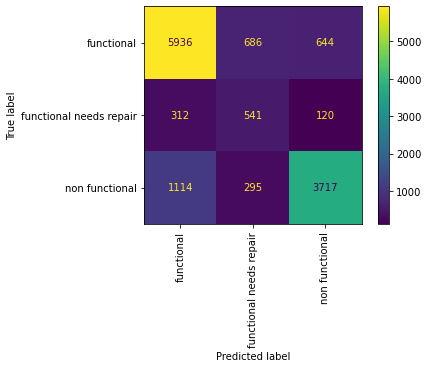

In [18]:
plot_confusion_matrix(xgboost_pipe, X_test, y_test, xticks_rotation='vertical');

In [19]:
model_predictions(xgboost_pipe, X_test, y_test)

The model correctly predicts 81.7% of the funtional wells.
The model correctly predicts 55.6% of the funtional-needs-repair wells.
The model correctly predicts 72.51% of the non-functional wells.


The model is overfitting, but the accuracy on the test data is 76.3% which is one of the better scores.  The model predicts 55.6% of functionl-needs-repair wells and 72.5% of non-functional wells (a combined 'score', if we add those percentages would be 128.11). 

Let's try setting the max depth to 10.

# XGBoost model 2 (max_depth=10)

In [27]:
xgboost_pipe_2 = imbPipeline([
    ('trans', transformer), 
    ('smote', SMOTE(random_state=42)),
    ('xgboost', XGBClassifier(max_depth=10, n_jobs=-1, verbosity=2, random_state=42))
])
xgboost_pipe_2.fit(X_train, y_train)

[15:44:08] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 570 extra nodes, 0 pruned nodes, max_depth=10
[15:44:09] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 640 extra nodes, 0 pruned nodes, max_depth=10
[15:44:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 530 extra nodes, 0 pruned nodes, max_depth=10
[15:44:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 602 extra nodes, 0 pruned nodes, max_depth=10
[15:44:12] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 632 extra nodes, 0 pruned nodes, max_depth=10
[15:44:13] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56

[15:44:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 584 extra nodes, 0 pruned nodes, max_depth=10
[15:45:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 460 extra nodes, 0 pruned nodes, max_depth=10
[15:45:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 538 extra nodes, 0 pruned nodes, max_depth=10
[15:45:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=10
[15:45:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=10
[15:45:05] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 40

[15:45:50] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 446 extra nodes, 0 pruned nodes, max_depth=10
[15:45:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=10
[15:45:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=10
[15:45:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 0 pruned nodes, max_depth=10
[15:45:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=10
[15:45:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 35

[15:46:39] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=10
[15:46:40] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=10
[15:46:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=10
[15:46:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=10
[15:46:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=10
[15:46:46] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 29

[15:47:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=10
[15:47:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=10
[15:47:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=10
[15:47:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=10
[15:47:31] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=10
[15:47:32] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 276

[15:48:13] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=10
[15:48:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=10
[15:48:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=10
[15:48:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=10
[15:48:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=10
[15:48:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 202 

[15:48:58] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=10
[15:48:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=10
[15:49:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=10
[15:49:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=10
[15:49:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=10
[15:49:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 16

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')),
                                                 ('num...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=10, min_child_weight=1, missing=nan,
                         

In [28]:
print('Accuracy Score Train:', xgboost_pipe_2.score(X_train,y_train))
print('Accuracy Score Test:', xgboost_pipe_2.score(X_test,y_test))

Accuracy Score Train: 0.9138545953360768
Accuracy Score Test: 0.7851851851851852


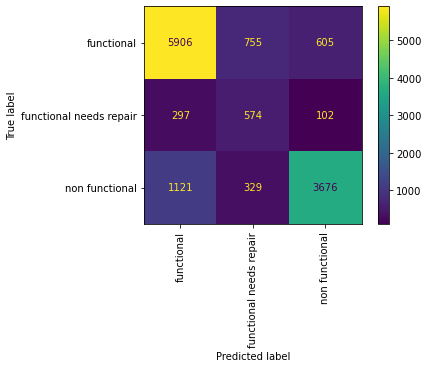

In [60]:
plot_confusion_matrix(xgboost_pipe_2, X_test, y_test, xticks_rotation='vertical');

In [29]:
model_predictions(xgboost_pipe_2, X_test, y_test)

The model correctly predicts 83.53% of the funtional wells.
The model correctly predicts 49.74% of the funtional-needs-repair wells.
The model correctly predicts 76.88% of the non-functional wells.


Accuracy test score improves, even though the overfitting is worse.  The model predicts 49.74% of functional-needs-repair wells and 76.88% of non-functional wells (combined score 126.62, worse than the default model).

# XGBoost Grid Search

We'll try a Grid search using the hyperparameters max_depth, learning_rate, and colsample_bytree.

In [48]:
xgboost_pipe_grid = {'xgboost__max_depth': [6, 10],
                    'xgboost__learning_rate': [.05, .3],
                    'xgboost__colsample_bytree': [.2, .4]}
gs_xgboost_pipe = GridSearchCV(estimator=xgboost_pipe, param_grid=xgboost_pipe_grid, cv=2)
gs_xgboost_pipe.fit(X_train, y_train)

[17:52:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:52:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:52:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:52:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:52:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:52:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra 

[17:52:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:52:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:52:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:52:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:52:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:52:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra 

[17:52:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:52:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:53:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:53:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:53:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:53:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra n

[17:53:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:53:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:53:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:53:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:53:04] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:53:04] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 110 extra n

[17:53:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:53:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:53:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:53:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:53:08] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:53:08] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 110 extra n

[17:53:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:53:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:53:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:53:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:53:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:53:12] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra n

[17:53:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:53:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:53:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:53:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:53:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:53:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 108 extra no

[17:53:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:53:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:53:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:53:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:53:38] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:53:38] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 68 extra 

[17:53:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:53:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:53:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:53:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:53:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:53:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra n

[17:53:46] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:53:46] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:53:46] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:53:47] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:53:47] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:53:47] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra

[17:53:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:53:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:53:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:53:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:53:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:53:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra

[17:53:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[17:53:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:53:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:53:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:53:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:53:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra 

[17:54:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[17:54:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:54:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:54:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:54:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:54:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 108 extra 

[17:54:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=10
[17:54:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=10
[17:54:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=10
[17:54:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 678 extra nodes, 0 pruned nodes, max_depth=10
[17:54:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 678 extra nodes, 0 pruned nodes, max_depth=10
[17:54:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 21

[17:54:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 472 extra nodes, 0 pruned nodes, max_depth=10
[17:54:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 544 extra nodes, 0 pruned nodes, max_depth=10
[17:54:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 514 extra nodes, 0 pruned nodes, max_depth=10
[17:54:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=10
[17:54:22] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 630 extra nodes, 0 pruned nodes, max_depth=10
[17:54:22] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 55

[17:54:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 438 extra nodes, 0 pruned nodes, max_depth=10
[17:54:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 656 extra nodes, 0 pruned nodes, max_depth=10
[17:54:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 586 extra nodes, 0 pruned nodes, max_depth=10
[17:54:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=10
[17:54:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=10
[17:54:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 62

[17:54:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 642 extra nodes, 0 pruned nodes, max_depth=10
[17:54:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 536 extra nodes, 0 pruned nodes, max_depth=10
[17:54:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 398 extra nodes, 0 pruned nodes, max_depth=10
[17:54:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=10
[17:54:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=10
[17:54:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 39

[17:54:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 550 extra nodes, 0 pruned nodes, max_depth=10
[17:54:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=10
[17:54:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=10
[17:54:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[17:54:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=10
[17:54:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 36

[17:54:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 746 extra nodes, 0 pruned nodes, max_depth=10
[17:54:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 662 extra nodes, 0 pruned nodes, max_depth=10
[17:54:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=10
[17:54:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 678 extra nodes, 0 pruned nodes, max_depth=10
[17:54:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 628 extra nodes, 0 pruned nodes, max_depth=10
[17:54:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 53

[17:55:06] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=10
[17:55:06] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 590 extra nodes, 0 pruned nodes, max_depth=10
[17:55:06] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 640 extra nodes, 0 pruned nodes, max_depth=10
[17:55:06] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 436 extra nodes, 0 pruned nodes, max_depth=10
[17:55:06] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 526 extra nodes, 0 pruned nodes, max_depth=10
[17:55:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 62

[17:55:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=10
[17:55:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 614 extra nodes, 0 pruned nodes, max_depth=10
[17:55:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=10
[17:55:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=10
[17:55:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=10
[17:55:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 28

[17:55:23] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=10
[17:55:23] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 416 extra nodes, 0 pruned nodes, max_depth=10
[17:55:23] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=10
[17:55:23] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=10
[17:55:23] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 634 extra nodes, 0 pruned nodes, max_depth=10
[17:55:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 38

[17:55:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 966 extra nodes, 0 pruned nodes, max_depth=10
[17:55:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=10
[17:55:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=10
[17:55:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 552 extra nodes, 0 pruned nodes, max_depth=10
[17:55:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 522 extra nodes, 0 pruned nodes, max_depth=10
[17:55:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 37

[17:55:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=10
[17:55:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=10
[17:55:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=10
[17:55:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=10
[17:55:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=10
[17:55:38] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 44

[17:55:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 512 extra nodes, 0 pruned nodes, max_depth=10
[17:55:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=10
[17:55:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 644 extra nodes, 0 pruned nodes, max_depth=10
[17:55:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=10
[17:55:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 500 extra nodes, 0 pruned nodes, max_depth=10
[17:55:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 30

[17:56:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:56:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:56:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:56:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:56:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:56:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra no

[17:56:06] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:56:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:56:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:56:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:56:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:56:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra no

[17:56:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:56:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:56:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:56:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:56:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[17:56:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 60 extra n

[17:56:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:56:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:56:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[17:56:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:56:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[17:56:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nod

[17:56:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[17:56:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:56:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:56:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[17:56:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[17:56:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nod

[17:56:22] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:56:22] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:56:22] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:56:22] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:56:22] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:56:22] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra no

[17:56:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[17:56:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[17:56:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:56:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:56:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:56:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra no

[17:56:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:56:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:56:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:56:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[17:56:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:56:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra no

[17:56:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:56:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:56:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:56:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:56:46] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:56:46] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra n

[17:56:49] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:56:49] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:56:50] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:56:50] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:56:50] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[17:56:50] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nod

[17:56:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:56:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:56:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[17:56:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:56:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:56:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nod

[17:56:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:56:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:56:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[17:56:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[17:57:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:57:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nod

[17:57:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:57:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:57:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:57:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[17:57:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[17:57:03] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nod

[17:57:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 796 extra nodes, 0 pruned nodes, max_depth=10
[17:57:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 298 extra nodes, 0 pruned nodes, max_depth=10
[17:57:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 460 extra nodes, 0 pruned nodes, max_depth=10
[17:57:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 712 extra nodes, 0 pruned nodes, max_depth=10
[17:57:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 356 extra nodes, 0 pruned nodes, max_depth=10
[17:57:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 14

[17:57:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[17:57:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=10
[17:57:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=10
[17:57:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 0 pruned nodes, max_depth=10
[17:57:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=10
[17:57:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 28

[17:57:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=10
[17:57:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=10
[17:57:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=10
[17:57:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=10
[17:57:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=10
[17:57:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 274

[17:57:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=10
[17:57:36] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=10
[17:57:36] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=10
[17:57:36] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=10
[17:57:36] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=10
[17:57:36] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 114

[17:57:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=10
[17:57:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=10
[17:57:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=10
[17:57:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=10
[17:57:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=10
[17:57:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80

[17:57:47] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=10
[17:57:47] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=10
[17:57:47] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=10
[17:57:47] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=10
[17:57:47] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=10
[17:57:47] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66

[17:58:04] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=10
[17:58:04] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=10
[17:58:04] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=10
[17:58:04] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=10
[17:58:05] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=10
[17:58:05] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 15

[17:58:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=10
[17:58:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=10
[17:58:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=10
[17:58:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=10
[17:58:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=10
[17:58:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 27

[17:58:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[17:58:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=10
[17:58:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 456 extra nodes, 0 pruned nodes, max_depth=10
[17:58:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=10
[17:58:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=10
[17:58:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 26

[17:58:23] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=10
[17:58:23] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=10
[17:58:23] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=10
[17:58:23] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=10
[17:58:23] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=10
[17:58:23] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 35

[17:58:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=10
[17:58:31] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=10
[17:58:31] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=10
[17:58:31] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=10
[17:58:31] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=10
[17:58:31] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 156

[17:58:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=10
[17:58:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=10
[17:58:38] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=10
[17:58:38] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=10
[17:58:38] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 410 extra nodes, 0 pruned nodes, max_depth=10
[17:58:38] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 230

[17:58:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:58:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:58:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:58:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:58:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:58:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra n

[17:59:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:59:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:59:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:59:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:59:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[17:59:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra 

[17:59:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:59:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:59:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:59:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:59:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:59:08] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra 

[17:59:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:59:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:59:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:59:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:59:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:59:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 102 extra 

[17:59:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[17:59:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:59:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:59:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17:59:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17:59:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 108 extra no

[17:59:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:59:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:59:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:59:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[17:59:27] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:59:27] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra no

[17:59:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:59:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:59:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:59:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:59:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:59:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 118 extra 

[17:59:47] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:59:47] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:59:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:59:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17:59:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:59:48] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 114 extra n

[17:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[17:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[17:59:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:59:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra n

[17:59:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:59:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:59:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[17:59:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:59:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:59:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 118 extra 

[18:00:04] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[18:00:04] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:00:04] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:00:05] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[18:00:05] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[18:00:05] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra 

[18:00:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:00:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[18:00:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:00:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[18:00:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[18:00:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 114 extra n

[18:00:23] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 450 extra nodes, 0 pruned nodes, max_depth=10
[18:00:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 710 extra nodes, 0 pruned nodes, max_depth=10
[18:00:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 520 extra nodes, 0 pruned nodes, max_depth=10
[18:00:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 528 extra nodes, 0 pruned nodes, max_depth=10
[18:00:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 532 extra nodes, 0 pruned nodes, max_depth=10
[18:00:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 65

[18:00:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=10
[18:00:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 580 extra nodes, 0 pruned nodes, max_depth=10
[18:00:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 620 extra nodes, 0 pruned nodes, max_depth=10
[18:00:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 436 extra nodes, 0 pruned nodes, max_depth=10
[18:00:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 568 extra nodes, 0 pruned nodes, max_depth=10
[18:00:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74

[18:00:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=10
[18:00:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 492 extra nodes, 0 pruned nodes, max_depth=10
[18:00:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 476 extra nodes, 0 pruned nodes, max_depth=10
[18:00:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 476 extra nodes, 0 pruned nodes, max_depth=10
[18:00:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 436 extra nodes, 0 pruned nodes, max_depth=10
[18:00:45] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52

[18:00:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=10
[18:00:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 622 extra nodes, 0 pruned nodes, max_depth=10
[18:00:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 750 extra nodes, 0 pruned nodes, max_depth=10
[18:00:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 514 extra nodes, 0 pruned nodes, max_depth=10
[18:00:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=10
[18:00:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 75

[18:01:05] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=10
[18:01:06] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=10
[18:01:06] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 568 extra nodes, 0 pruned nodes, max_depth=10
[18:01:06] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=10
[18:01:06] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=10
[18:01:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 79

[18:01:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=10
[18:01:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 512 extra nodes, 0 pruned nodes, max_depth=10
[18:01:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 498 extra nodes, 0 pruned nodes, max_depth=10
[18:01:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=10
[18:01:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=10
[18:01:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 63

[18:01:31] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 462 extra nodes, 0 pruned nodes, max_depth=10
[18:01:31] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 554 extra nodes, 0 pruned nodes, max_depth=10
[18:01:32] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=10
[18:01:32] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=10
[18:01:32] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 378 extra nodes, 0 pruned nodes, max_depth=10
[18:01:32] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 55

[18:01:56] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 634 extra nodes, 0 pruned nodes, max_depth=10
[18:01:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 714 extra nodes, 0 pruned nodes, max_depth=10
[18:01:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=10
[18:01:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=10
[18:01:58] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=10
[18:01:58] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 38

[18:02:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 672 extra nodes, 0 pruned nodes, max_depth=10
[18:02:11] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 574 extra nodes, 0 pruned nodes, max_depth=10
[18:02:12] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 592 extra nodes, 0 pruned nodes, max_depth=10
[18:02:12] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 520 extra nodes, 0 pruned nodes, max_depth=10
[18:02:13] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=10
[18:02:13] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 48

[18:02:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 446 extra nodes, 0 pruned nodes, max_depth=10
[18:02:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 592 extra nodes, 0 pruned nodes, max_depth=10
[18:02:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 480 extra nodes, 0 pruned nodes, max_depth=10
[18:02:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=10
[18:02:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 580 extra nodes, 0 pruned nodes, max_depth=10
[18:02:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 49

[18:02:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=10
[18:02:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=10
[18:02:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 592 extra nodes, 0 pruned nodes, max_depth=10
[18:02:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=10
[18:02:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 536 extra nodes, 0 pruned nodes, max_depth=10
[18:02:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 59

[18:02:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=10
[18:02:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 444 extra nodes, 0 pruned nodes, max_depth=10
[18:02:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 708 extra nodes, 0 pruned nodes, max_depth=10
[18:02:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 322 extra nodes, 0 pruned nodes, max_depth=10
[18:02:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=10
[18:02:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 44

[18:03:09] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=10
[18:03:09] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=10
[18:03:09] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=10
[18:03:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=10
[18:03:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=10
[18:03:10] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 42

[18:03:32] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:03:32] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[18:03:32] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:03:33] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:03:33] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:03:33] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 108 extra n

[18:03:40] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[18:03:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[18:03:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[18:03:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[18:03:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:03:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nod

[18:03:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[18:03:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[18:03:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:03:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[18:03:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:03:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra no

[18:04:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[18:04:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:04:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:04:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:04:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:04:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56 extra 

[18:04:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[18:04:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[18:04:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[18:04:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[18:04:31] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:04:31] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nod

[18:04:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:04:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:04:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:04:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[18:04:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[18:04:55] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra no

[18:05:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:05:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:05:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[18:05:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[18:05:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:05:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra 

[18:05:23] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:05:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:05:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[18:05:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[18:05:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:05:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra n

[18:05:33] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[18:05:33] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[18:05:34] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:05:34] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[18:05:34] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[18:05:34] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nod

[18:05:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:05:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[18:05:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[18:05:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[18:05:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[18:05:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nod

[18:06:05] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[18:06:06] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[18:06:06] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:06:06] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[18:06:06] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[18:06:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nod

[18:06:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[18:06:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[18:06:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[18:06:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[18:06:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[18:06:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nod

[18:06:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 506 extra nodes, 0 pruned nodes, max_depth=10
[18:06:41] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 564 extra nodes, 0 pruned nodes, max_depth=10
[18:06:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 534 extra nodes, 0 pruned nodes, max_depth=10
[18:06:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 624 extra nodes, 0 pruned nodes, max_depth=10
[18:06:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 712 extra nodes, 0 pruned nodes, max_depth=10
[18:06:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 66

[18:07:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 486 extra nodes, 0 pruned nodes, max_depth=10
[18:07:00] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=10
[18:07:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=10
[18:07:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=10
[18:07:01] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=10
[18:07:02] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 38

[18:07:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=10
[18:07:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=10
[18:07:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=10
[18:07:16] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=10
[18:07:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 374 extra nodes, 0 pruned nodes, max_depth=10
[18:07:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 14

[18:07:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=10
[18:07:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=10
[18:07:38] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=10
[18:07:38] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=10
[18:07:39] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=10
[18:07:39] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 210

[18:07:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=10
[18:07:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=10
[18:07:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=10
[18:07:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=10
[18:07:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=10
[18:07:54] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 46 

[18:08:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=10
[18:08:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 296 extra nodes, 0 pruned nodes, max_depth=10
[18:08:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=10
[18:08:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=10
[18:08:08] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=10
[18:08:08] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 172

[18:08:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=10
[18:08:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=10
[18:08:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=10
[18:08:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=10
[18:08:22] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=10
[18:08:22] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 150

[18:08:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=10
[18:08:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 322 extra nodes, 0 pruned nodes, max_depth=10
[18:08:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=10
[18:08:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=10
[18:08:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=10
[18:08:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 44

[18:09:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=10
[18:09:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=10
[18:09:07] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=10
[18:09:08] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=10
[18:09:08] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=10
[18:09:08] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 14

[18:09:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=10
[18:09:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=10
[18:09:28] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=10
[18:09:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=10
[18:09:29] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=10
[18:09:30] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 452

[18:09:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=10
[18:09:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=10
[18:09:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=10
[18:09:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=10
[18:09:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=10
[18:09:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 23

[18:09:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=10
[18:09:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=10
[18:09:58] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=10
[18:09:58] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=10
[18:09:58] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=10
[18:09:58] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 17

[18:10:12] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=10
[18:10:12] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 0 pruned nodes, max_depth=10
[18:10:13] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=10
[18:10:13] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=10
[18:10:13] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=10
[18:10:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 11

[18:11:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 742 extra nodes, 0 pruned nodes, max_depth=10
[18:11:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 550 extra nodes, 0 pruned nodes, max_depth=10
[18:11:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 674 extra nodes, 0 pruned nodes, max_depth=10
[18:11:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 856 extra nodes, 0 pruned nodes, max_depth=10
[18:11:22] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 348 extra nodes, 0 pruned nodes, max_depth=10
[18:11:23] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 38

[18:11:49] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 732 extra nodes, 0 pruned nodes, max_depth=10
[18:11:49] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 718 extra nodes, 0 pruned nodes, max_depth=10
[18:11:50] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=10
[18:11:50] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 892 extra nodes, 0 pruned nodes, max_depth=10
[18:11:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=10
[18:11:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 45

[18:12:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=10
[18:12:17] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 0 pruned nodes, max_depth=10
[18:12:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=10
[18:12:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 330 extra nodes, 0 pruned nodes, max_depth=10
[18:12:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=10
[18:12:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 43

[18:12:49] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 374 extra nodes, 0 pruned nodes, max_depth=10
[18:12:50] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 518 extra nodes, 0 pruned nodes, max_depth=10
[18:12:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=10
[18:12:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=10
[18:12:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=10
[18:12:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 32

[18:13:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=10
[18:13:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 392 extra nodes, 0 pruned nodes, max_depth=10
[18:13:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=10
[18:13:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=10
[18:13:22] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=10
[18:13:22] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 20

[18:13:49] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 474 extra nodes, 0 pruned nodes, max_depth=10
[18:13:50] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=10
[18:13:50] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=10
[18:13:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=10
[18:13:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=10
[18:13:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 23

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_t...
                                                      missing=nan,
                                                      monotone_constraints='()',
                                                      n_estimators=100,
 

In [49]:
gs_xgboost_pipe.best_params_

{'xgboost__colsample_bytree': 0.4,
 'xgboost__learning_rate': 0.3,
 'xgboost__max_depth': 10}

In [50]:
print('Accuracy Score Train:', gs_xgboost_pipe.score(X_train,y_train))
print('Accuracy Score Test:', gs_xgboost_pipe.score(X_test,y_test))

Accuracy Score Train: 0.9027808953734879
Accuracy Score Test: 0.7837635615413393


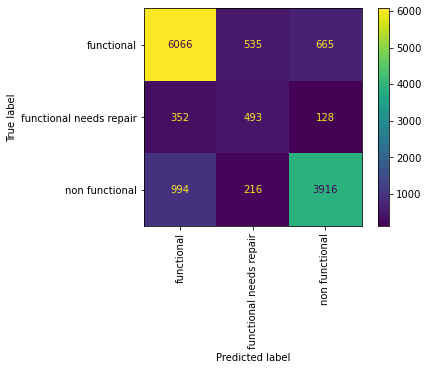

In [59]:
plot_confusion_matrix(gs_xgboost_pipe, X_test, y_test, xticks_rotation='vertical');

In [55]:
model_predictions(gs_xgboost_pipe, X_test, y_test)

The model correctly predicts 83.48% of the funtional wells.
The model correctly predicts 50.67% of the funtional-needs-repair wells.
The model correctly predicts 76.39% of the non-functional wells.


The GridSearch suggests using colsample_bytree=.4, learning_rate=.3, and max_depth=10.  Using these hyperparameters, our test accuracy score is actually slightly lower than model 2 (default, except max_depth=10).  The model correctly predicts 50.67% of needs-repair wells, and 76.39% of non-functional wells (combined score of 127.06, still worse than the default).  

# XGBoost model 4

Since we are most interested in the predictions of needs-repair and non-functional wells (as opposed to the overall accuracy score per se), let's try the lowering the learning rate to .05 and see what that does.

In [45]:
xgboost_pipe_4 = imbPipeline([
    ('trans', transformer), 
    ('smote', SMOTE(random_state=42)),
    ('xgboost', XGBClassifier(max_depth=10, learning_rate=.05, colsample_bytree=.4, 
                              n_jobs=-1, verbosity=2, random_state=42))
])
xgboost_pipe_4.fit(X_train, y_train)

[17:35:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 676 extra nodes, 0 pruned nodes, max_depth=10
[17:35:24] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 544 extra nodes, 0 pruned nodes, max_depth=10
[17:35:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[17:35:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 572 extra nodes, 0 pruned nodes, max_depth=10
[17:35:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 822 extra nodes, 0 pruned nodes, max_depth=10
[17:35:26] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 63

[17:35:50] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 506 extra nodes, 0 pruned nodes, max_depth=10
[17:35:50] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 670 extra nodes, 0 pruned nodes, max_depth=10
[17:35:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 1066 extra nodes, 0 pruned nodes, max_depth=10
[17:35:51] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=10
[17:35:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 706 extra nodes, 0 pruned nodes, max_depth=10
[17:35:52] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 6

[17:36:12] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=10
[17:36:13] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 714 extra nodes, 0 pruned nodes, max_depth=10
[17:36:13] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 836 extra nodes, 0 pruned nodes, max_depth=10
[17:36:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=10
[17:36:14] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 684 extra nodes, 0 pruned nodes, max_depth=10
[17:36:15] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 67

[17:36:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 566 extra nodes, 0 pruned nodes, max_depth=10
[17:36:35] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=10
[17:36:36] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 1006 extra nodes, 0 pruned nodes, max_depth=10
[17:36:36] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=10
[17:36:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 572 extra nodes, 0 pruned nodes, max_depth=10
[17:36:37] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 7

[17:36:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 416 extra nodes, 0 pruned nodes, max_depth=10
[17:36:57] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 812 extra nodes, 0 pruned nodes, max_depth=10
[17:36:58] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 938 extra nodes, 0 pruned nodes, max_depth=10
[17:36:58] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 518 extra nodes, 0 pruned nodes, max_depth=10
[17:36:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=10
[17:36:59] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 68

[17:37:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=10
[17:37:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=10
[17:37:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 1082 extra nodes, 0 pruned nodes, max_depth=10
[17:37:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=10
[17:37:20] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=10
[17:37:21] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 6

[17:37:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=10
[17:37:42] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=10
[17:37:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=10
[17:37:43] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 474 extra nodes, 0 pruned nodes, max_depth=10
[17:37:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 714 extra nodes, 0 pruned nodes, max_depth=10
[17:37:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/tree/updater_prune.cc:101: tree pruning end, 56

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')),
                                                 ('num...
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.05,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               m

In [46]:
print('Accuracy Score Train:', xgboost_pipe_4.score(X_train,y_train))
print('Accuracy Score Test:', xgboost_pipe_4.score(X_test,y_test))

Accuracy Score Train: 0.8120962713555306
Accuracy Score Test: 0.7598952487841377


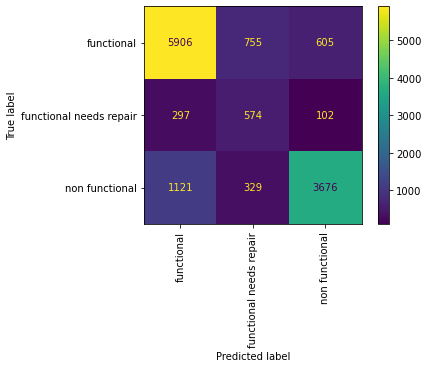

In [58]:
plot_confusion_matrix(xgboost_pipe_4, X_test, y_test, xticks_rotation='vertical');

In [47]:
model_predictions(xgboost_pipe_4, X_test, y_test)

The model correctly predicts 81.28% of the funtional wells.
The model correctly predicts 58.99% of the funtional-needs-repair wells.
The model correctly predicts 71.71% of the non-functional wells.


The accuracy drops compared to the GridSearch, though there is less overfitting.  This model predicts 58.99% of needs-repair wells (a large improvement) and 71.71% (a smaller decline) of non-functional wells (for a combined 'score' of 130.7, the best XGBoost model).  We will consider this our best XGBoost model.  